In [90]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [38]:
def get_kospi_top_stocks():
    kospi_top_rate_of_rise = 'http://stock.kakao.com/api/trends/ordered_stocks.json?key=top_rate_of_rise&market=kospi&limit=100'
    kospi_top_rise_stocks = []
    r = requests.get(top_rate_of_rise)
    while (True):
        data = r.json()
        kospi_top_rise_stocks += data['stocks']
        nextCursor = data['nextCursor']
        if nextCursor:
            r = requests.get(kospi_top_rate_of_rise + '&cursor={}'.format(nextCursor))
        else:
            break
    return kospi_top_rise_stocks

In [255]:
def get_top_stocks(market):
    top_rate_of_rise = 'http://stock.kakao.com/api/trends/ordered_stocks.json?key=top_rate_of_rise&market={}&limit=100'.format(market)
    top_rise_stocks = []
    r = requests.get(top_rate_of_rise)
    while (True):
        data = r.json()
        top_rise_stocks += data['stocks']
        nextCursor = data['nextCursor']
        if nextCursor:
            r = requests.get(top_rate_of_rise + '&cursor={}'.format(nextCursor))
        else:
            break
    return top_rise_stocks

In [256]:
def get_kospi_top_stocks():
    return get_top_stocks('kospi')

In [257]:
def get_kosdaq_top_stocks():
    return get_top_stocks('kosdaq')

In [258]:
kosdaq = get_kosdaq_top_stocks()

In [262]:
kosdaq[0]['code']

'KR7077280006'

In [314]:
def get_candle_dataframe(api, code):
    r = requests.get(api + code)
    data = r.json()
    for d in data:
        d['candleTime'] = datetime.strptime(d['candleTime'], '%Y-%m-%d %H:%M:%S.%f')   
    df = pd.DataFrame(data, 
                  columns=['code', 'shortCode', 'candleTime', 'openingPrice', 'tradePrice', 
                           'lowPrice', 'highPrice', 'accTradePrice', 'accTradeVolume'])
    df = df.set_index('candleTime')
    df = df.sort_index()
    return df

In [315]:
def get_day_candles(code):
    api = 'http://quotation-api.dunamu.com/v1/candle/days?count=500&code='
    df = get_candle_dataframe(api, code)
    add_day_candle_index(df)
    return df

In [316]:
def add_day_candle_index(df):
    df['bol_40p2'] = df['tradePrice'].rolling(window=40).mean() + (df['tradePrice'].rolling(window=40).std() * 2)
    df['eye_base'] = (df['tradePrice'].rolling(window=26).min() + df['tradePrice'].rolling(window=26).max()) / 2
    df['eye_trans'] = (df['tradePrice'].rolling(window=9).min() + df['tradePrice'].rolling(window=9).max()) / 2
    df['eye_fore_1'] = ((df['eye_base'] + df['eye_trans']) / 2).shift(26)
    df['eye_fore_2'] = ((df['tradePrice'].rolling(window=52).min() + df['tradePrice'].rolling(window=52).max()) / 2).shift(26)
    df['ema_224'] = df['tradePrice'].ewm(span=224, min_periods=223).mean()
    df['ma_40'] = df['tradePrice'].rolling(window=40).mean()
    df['ma_60'] = df['tradePrice'].rolling(window=60).mean()

In [317]:
def day_plot(df, x_range=None):
    df[['tradePrice','bol_40p2', 'eye_base', 'eye_fore_1', 'eye_fore_2', 'ema_224', 'ma_40', 'ma_60']].plot(figsize=(15,10), xlim=x_range)

In [318]:
def get_week_candles(code):
    api = 'http://quotation-api.dunamu.com/v1/candle/weeks?count=500&code='
    df = get_candle_dataframe(api, code)
    add_week_candle_index(df)
    return df

In [319]:
def add_week_candle_index(df):
    df['env_15m20'] = df['tradePrice'].rolling(window=15).mean() * (1-0.2)
    df['env_15m30'] = df['tradePrice'].rolling(window=15).mean() * (1-0.3)
    df['env_10'] = df['tradePrice'].rolling(window=10).mean()
    df['env_10p40'] = df['tradePrice'].rolling(window=10).mean() * (1+0.4)
    df['env_10p20'] = df['tradePrice'].rolling(window=10).mean() * (1+0.2)

In [320]:
def week_plot(df, x_range=None):
    df[['tradePrice','env_10', 'env_10p40', 'env_10p20']].plot(figsize=(15,10), xlim=x_range)

In [321]:
def get_minute_candles(code, minute=1):
    api = 'http://quotation-api.dunamu.com/v1/candle/minutes/{}?count=500&code='.format(minute)
    df = get_candle_dataframe(api, code)
    add_minute_candle_index(df)
    return df

In [322]:
def add_minute_candle_index(df):
    df['eye_base'] = (df['tradePrice'].rolling(window=26).min() + df['tradePrice'].rolling(window=26).max()) / 2
    df['eye_trans'] = (df['tradePrice'].rolling(window=9).min() + df['tradePrice'].rolling(window=9).max()) / 2
    df['eye_fore_1'] = ((df['eye_base'] + df['eye_trans']) / 2).shift(26)
    df['bol_40p2'] = df['tradePrice'].rolling(window=40).mean() + (df['tradePrice'].rolling(window=40).std() * 2)
    df['env_10p6'] = df['tradePrice'].rolling(window=10).mean() * (1+0.6)
    df['ma_5'] = df['tradePrice'].rolling(window=5).mean()

In [323]:
def minute_plot(df, x_range=None):
    df[['tradePrice','eye_base', 'eye_fore_1', 'bol_40p2', 'env_10p6', 'ma_5']].plot(figsize=(15,10), xlim=x_range)

In [324]:
df_week = get_week_candles(kosdaq[0]['code'])

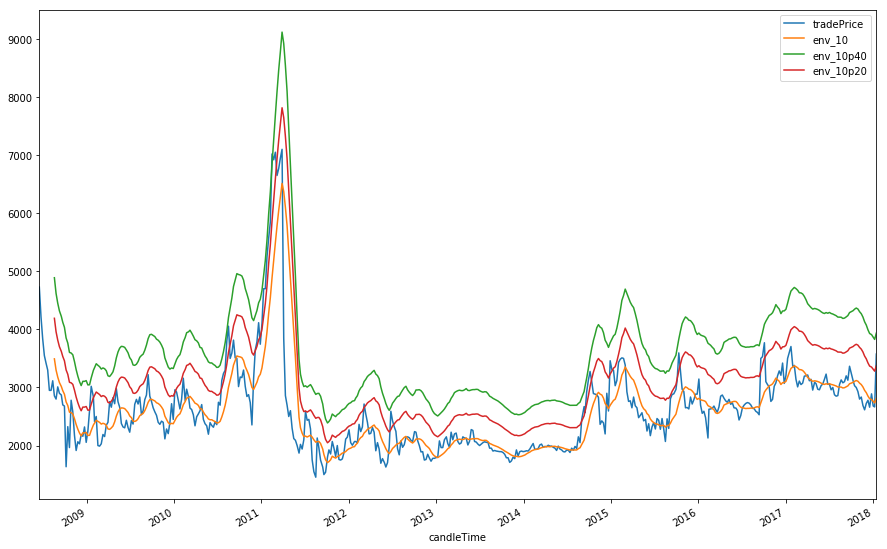

In [325]:
week_plot(df_week)

In [326]:
df_day = get_day_candles(kosdaq[0]['code'])

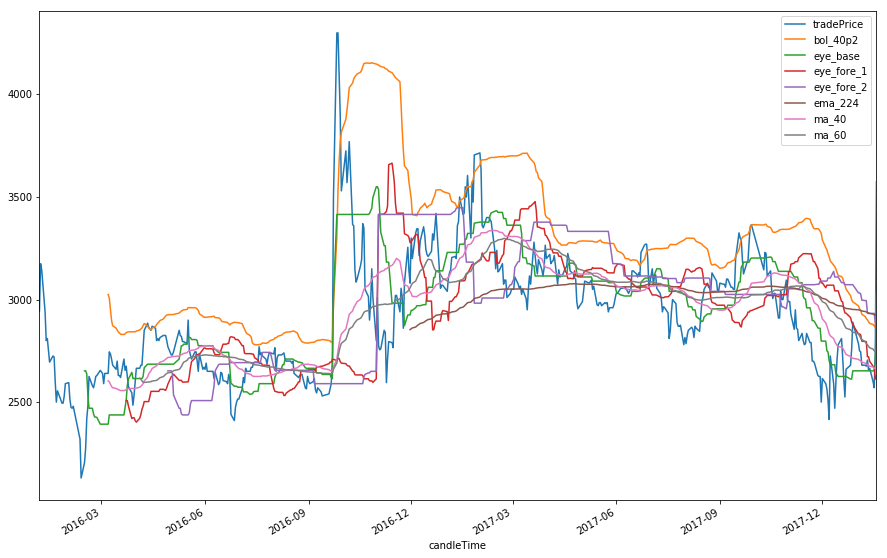

In [327]:
day_plot(df_day)

In [330]:
df_minute = get_minute_candles(kosdaq[0]['code'], 5)

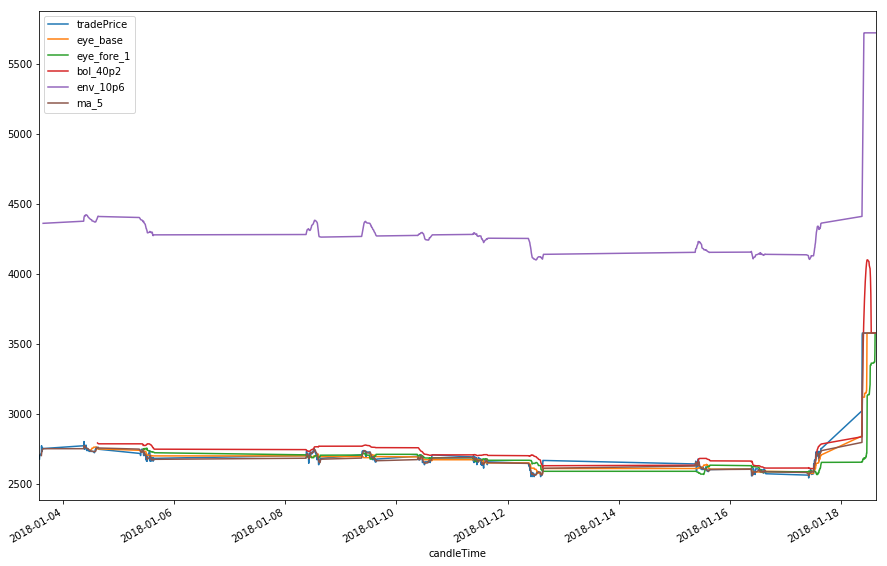

In [331]:
minute_plot(df_minute)